In [70]:
import torch
torch.cuda.empty_cache()
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

## Data preparation

In [71]:
import lstm_unet

PATH = "lstm_unetFULL.pt"

model = lstm_unet.LSTMUNet(1,2).to(dev)
model.load_state_dict(torch.load(PATH,map_location=dev))

<All keys matched successfully>

In [72]:
import pandas as pd

df = pd.read_json("data/dataset_seq.json")
dataset = pd.read_json("./data/dataset_seq.json")
dataset = dataset.sample(frac=1,random_state=0)[:] # shuffle
#dataset = dataset[:500].copy()
split = int(len(dataset) * 0.9)
df = test_df =  dataset[split:].copy()


In [73]:
from torchvision.transforms import transforms, Lambda
import albumentations as A
from albumentations.pytorch import ToTensorV2
IMAGE_SIZE = 160
CROP_NON_EMPTY_CHANCE = 0.7
transform_test = A.Compose([
                        A.Resize(IMAGE_SIZE, IMAGE_SIZE,always_apply=True),
                        # A.RandomCrop(IMAGE_SIZE, IMAGE_SIZE,always_apply=True),
                       # A.Resize(IMAGE_SIZE, IMAGE_SIZE,always_apply=True),
                       # A.CropNonEmptyMaskIfExists(IMAGE_SIZE, IMAGE_SIZE,always_apply=True ),
                       # A.PadIfNeeded(1120,1120,border_mode=0) ,
                        ToTensorV2(),
                    ]   
                     ,additional_targets={ 'image1': 'image','image2': 'image','image3': 'image','image4': 'image'
                                             ,'mask1': 'mask','mask2': 'mask','mask3': 'mask','mask4': 'mask'}  
                    )

torch.Size([5, 1, 160, 160])


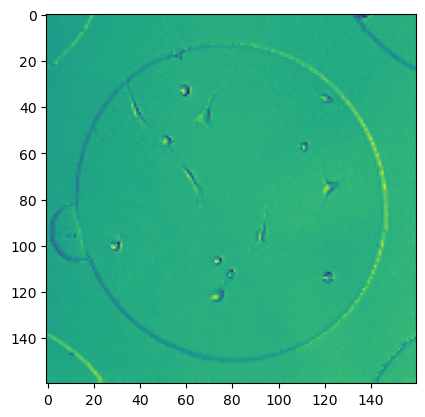

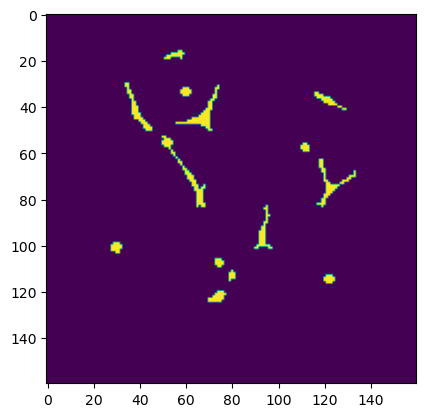

In [74]:
from torch.utils.data import Dataset, DataLoader
from skimage import color, io
import numpy as np
import matplotlib.pyplot as plt
class CellSegmentationDataset(Dataset):
    def __init__(self, data, transform):
        super().__init__()
        self.data = data
        self.transform = transform
        self.to_tensor = transforms.ToTensor()
    def __len__(self):
        return len(self.data)

    def GetWithLabels(self, idx):
        imgs = []
        anots =[]
        for p in zip(self.data["seqence"].iloc[idx], self.data["anot"].iloc[idx]):
            image_filepath = p[0]
            mask_filepath = p[1]
            img =  io.imread(image_filepath).astype(np.uint8)
            mask = io.imread(mask_filepath).astype(np.uint8)
            imgs.append(img)
            anots.append(mask)
        transformed = self.transform(image=imgs[0],image1=imgs[1],image2=imgs[2],image3=imgs[3],image4=imgs[4],
                       mask=anots[0],mask1=anots[1],mask2=anots[2],mask3=anots[3],mask4=anots[4])
       
        image = torch.stack([transformed["image"],transformed["image1"],transformed["image2"],transformed["image3"],transformed["image4"]])
        anot =  torch.stack([transformed["mask"],transformed["mask1"],transformed["mask2"],transformed["mask3"],transformed["mask4"]]) 
        return image, anot.long()
        
    def __getitem__(self, idx):
        imgs = []
        anots =[]
        for p in zip(self.data["seqence"].iloc[idx], self.data["anot"].iloc[idx]):
            image_filepath = p[0]
            mask_filepath = p[1]
            img =  io.imread(image_filepath).astype(np.uint8)
            mask = io.imread(mask_filepath).astype(np.uint8)
            imgs.append(img)
            anots.append(mask)
        transformed = self.transform(image=imgs[0],image1=imgs[1],image2=imgs[2],image3=imgs[3],image4=imgs[4],
                       mask=anots[0],mask1=anots[1],mask2=anots[2],mask3=anots[3],mask4=anots[4])
       
        image = torch.stack([transformed["image"],transformed["image1"],transformed["image2"],transformed["image3"],transformed["image4"]])
        anot =  torch.stack([transformed["mask"],transformed["mask1"],transformed["mask2"],transformed["mask3"],transformed["mask4"]]) > 0
        return image, anot.long()
    
dataset = CellSegmentationDataset(df,transform_test)
idx = 0
out = dataset[idx]
print(out[0].shape)
plt.imshow(out[0][0][0].numpy())
plt.show()
plt.imshow(out[1][0].numpy())
plt.show()



## Evaluate the model

In [75]:
from tqdm.notebook import tqdm
from torchmetrics import JaccardIndex
def GetDetection(index,dataset,model):
    test_data,anots = dataset[index]
    
    model.eval()
    with torch.no_grad():
       outputs = model(test_data[None,:].to(dev))
       outputs = torch.sigmoid(outputs)
       bg, fg = outputs[0][-1] # only last element in the sequence 
       rec = fg.to("cpu")
    return bg.to("cpu"),rec

def Evaluate(dataset, model,th):
    scores = []
    jaccard = JaccardIndex(num_classes=2,task="binary")
    for i in tqdm(range(0,len(dataset))):
        bg, rec = GetDetection(i,dataset,model)
        _,anots = dataset[i]
        anot = anots[-1]  # only last element in the sequence 
        rec_th = rec > th
        # plt.imshow(rec_th)
        # plt.show()
      
        intersection = torch.logical_and(rec_th, anot)
        union = torch.logical_or(rec_th, anot)
        iou_score = torch.sum(intersection) / torch.sum(union)
        scores.append(iou_score)
    return np.array(scores)

In [76]:
scores = Evaluate(dataset,model,0.4)
print(np.mean(scores))

  0%|          | 0/275 [00:00<?, ?it/s]

0.5478158


# Vizutalization

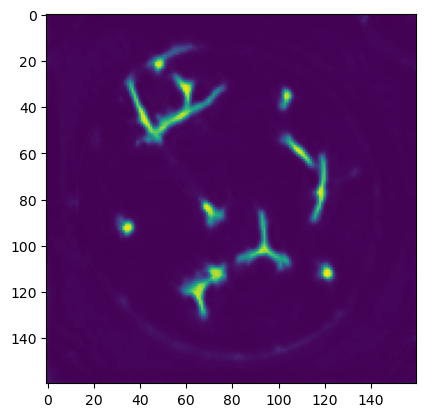

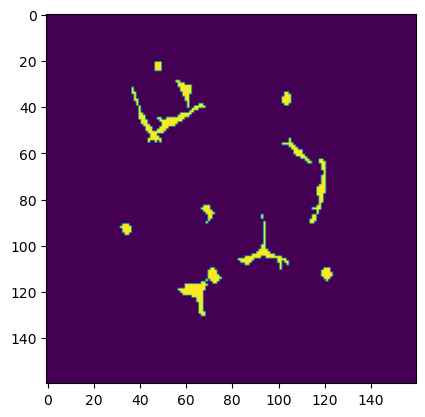

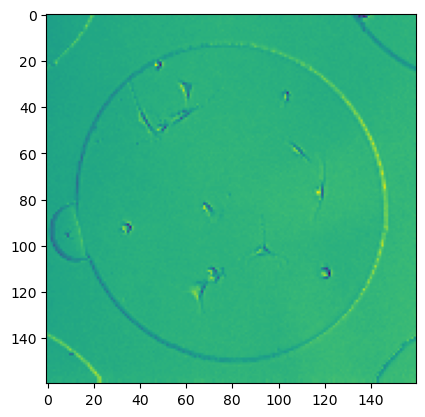

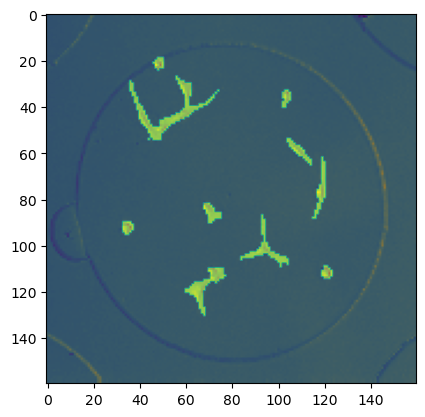

tensor(0.6025)


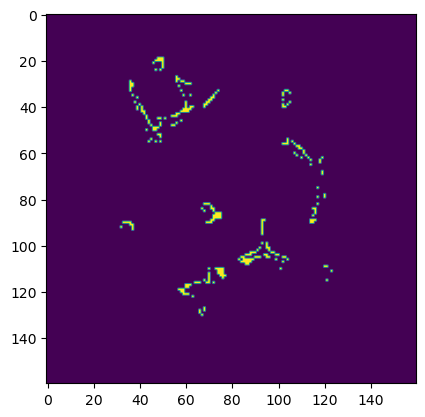

In [83]:
index = 0

_,rec = GetDetection(index,dataset,model)
test_data,anots = dataset[index]
anot = anots[-1]
rec_th = rec>0.4
plt.imshow(rec)
plt.show()

plt.imshow(anots[-1])
plt.show()
plt.imshow(test_data[-1][0])
plt.show()

plt.imshow(test_data[-1][0])
plt.imshow(rec_th,alpha=.5)
plt.show()
intersection = torch.logical_and(rec_th, anot)
union = torch.logical_or(rec_th, anot)
iou_score = torch.sum(intersection) / torch.sum(union)
print(iou_score)


plt.imshow(rec_th^anot)